c:\Users\Moe\Desktop\Aircomm-Insight-Project\aircomm\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Moe\AppData\Local\Temp\ipykernel_9176\3090868639.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, y="feature", x="importance", palette="viridis")


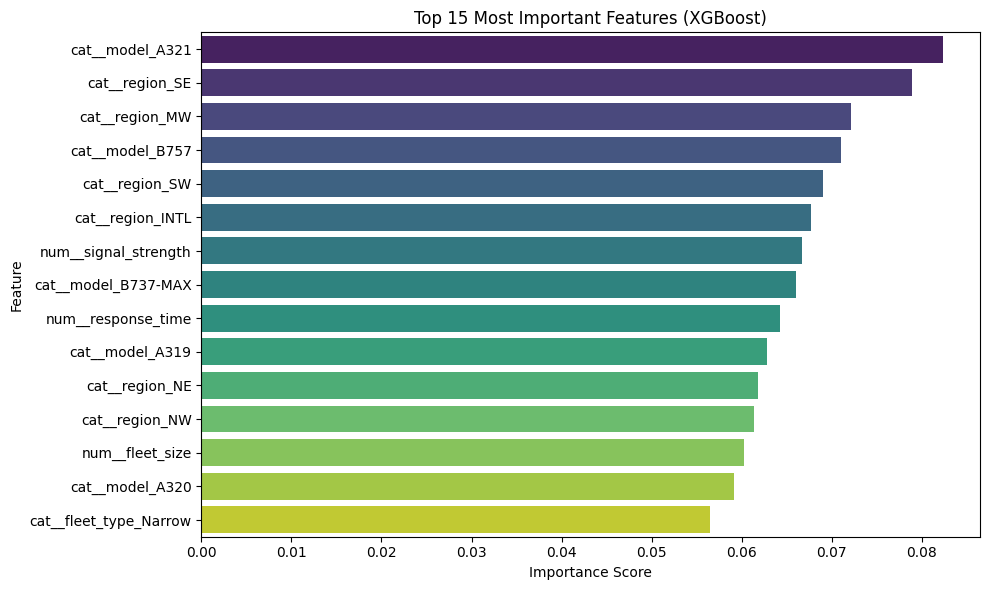

In [1]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
conn = sqlite3.connect("../data/aircomm_insight.db")
query = """
SELECT 
    l.region,
    l.signal_strength,
    l.response_time,
    e.model,
    e.fleet_type,
    e.hub,
    e.fleet_size,
    CASE WHEN l.error_code != 0 THEN 1 ELSE 0 END AS error_flag
FROM aircraft_logs l
JOIN aircraft_metadata_enriched e ON l.aircraft_id = e.aircraft_id
"""
df = pd.read_sql(query, conn)
conn.close()

# Split X and y
X = df.drop("error_flag", axis=1)
y = df["error_flag"]

# Preprocess
categorical = ["region", "model", "fleet_type", "hub"]
numerical = ["signal_strength", "response_time", "fleet_size"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

# Transform data manually for XGBoost
X_prepped = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_prepped, y, test_size=0.3, random_state=42, stratify=y)
xgb_model.fit(X_train, y_train)

# Feature importance plot
importances = xgb_model.feature_importances_
feat_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_df = feat_df.sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, y="feature", x="importance", palette="viridis")
plt.title("Top 15 Most Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.41      0.37      0.39       331
           1       0.54      0.58      0.56       419

    accuracy                           0.49       750
   macro avg       0.48      0.48      0.48       750
weighted avg       0.48      0.49      0.48       750



<Figure size 600x500 with 0 Axes>

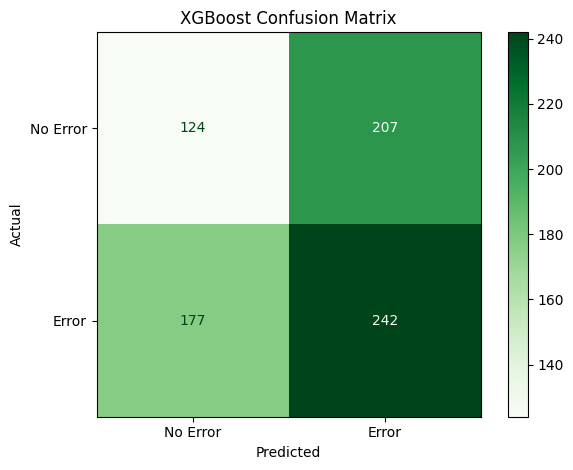

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Print classification report
print("Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["No Error", "Error"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Greens", values_format="d")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.grid(False)
plt.tight_layout()
plt.show()


### 📊 Classification Report – XGBoost (Aircraft Error Prediction)


---

### 🧠 Interpretation

#### 🔹 Class 0 – "No Error"
- **Precision (0.41):** When the model predicted no error, it was correct 41% of the time.
- **Recall (0.37):** It correctly identified 37% of flights that had no errors.
- 📉 The model struggles to distinguish clean flights, which can result in many false positives.

#### 🔹 Class 1 – "Error"
- **Precision (0.54):** When predicting an error, it was correct 54% of the time.
- **Recall (0.58):** It successfully caught 58% of all real errors.
- ✅ Slightly better performance for the error class, but recall and precision could still be improved.

#### 🎯 Overall Accuracy: **49%**
- The model is performing close to random guessing — indicating that **features or model tuning needs improvement**.

---

### ✅ Summary

> “The XGBoost model outperformed Logistic Regression slightly on precision and recall for error detection, but overall accuracy remains low (49%).  
>
> It captures more failure events than random chance, but still produces many false positives and misses clean flights.  
>
> I would next improve the signal-to-noise ratio through:
> - Feature engineering
> - Class balancing (SMOTE or undersampling)
> - Hyperparameter tuning or model stacking”

